# Projet 3: Concevez une application au service de la santé publique

Open Food Facts est une association à but non lucratif composée de volontaires qui fournit une base de données de produits alimentaires qui répertorie les ingrédients, les allergènes, la composition nutritionnelle et toutes les informations présentes sur les étiquettes des aliments. 

Toute la base de données est publiée sous forme de données ouvertes (open data) qui peuvent être utilisées par tous et pour tous usages.

La base de données contient:
- des **informations générales**: code barre du produit, url du produit sur le site d'Open Food Facts, contributeur qui a ajouté le produit pour la première fois, date de l'ajout et de la modification d'un produit, le nom du produit, sa quantité, son image
- des informations sur le **type du produit**: marque, catégorie, label
- des informations sur sa **provenance**: origine, lieu de transformation, pays,villes et magasins où sont proposés les produits
- des informations sur le type d'**emballage** du produit
- des informations sur la **composition** du produit: ingrédients, additifs, allergènes, nutriments, vitamines
- des **scores**: empreinte carbonne, nutriscore (défini par la FSA et sa version adaptée au marché français), grade de nutrition (de A à E)

Le nutriscore est attribué sur la base d’un score prenant en compte pour 100 gr ou 100 mL de produit, la teneur :
- en **nutriments et aliments à favoriser** (fibres, protéines, fruits, légumes, légumineuses, fruits à coques, huile de colza, de noix et d’olive),
- et en **nutriments à limiter** (énergie, acides gras saturés, sucres, sel)

Après calcul, le score obtenu par un produit permet de lui attribuer une lettre et une couleur.

L'agence "Santé publique France" a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation.

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Visualisation et chargement du dataset](#dataset)
3. [Mots qui apparaissent le plus souvent dans le nom des variables](#words)
4. [Autres variables](#misc)
5. [Sélection de variables pertinentes en lien avec le choix d'application](#selec_var)
6. [Doublons](#doublons)
7. [Gestion des valeurs aberrantes](#outliers)
8. [Gestion des valeurs manquantes](#nan)    

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
import numpy as np # pour l'algèbre linéaire
import pandas as pd # pour l'analyse de données
import collections # pour compter l'occurence de mots
from collections import Counter

import seaborn as sns # datavisualisation
import matplotlib.pyplot as plt # datavisualisation
from matplotlib.gridspec import GridSpec # visualisation sous forme de grille
from wordcloud import WordCloud # nuage de mots

In [2]:
#plt.rcParams.keys()

In [3]:
# Configuration générale des graphiques
parameters = {'axes.labelsize': 13, 'axes.titlesize': 16, 'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

In [4]:
# Modification de l'affichage des lignes et colonnes pour plus de lisibilité
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)

In [5]:
#import warnings
#warnings.filterwarnings('ignore')

## Visualisation et chargement du dataset <a class="anchor" id="dataset"></a>

In [6]:
#openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t')

Lorsque l'on tente de charger directement le dataset, on obtient une erreur indiquant l'index des colonnes posant problème (type mixte). Afin de récupérer le nom des variables pour leur affecter un dtypes avant import, nous allons charger uniquement les 5 premières lignes et récupérer les colonnes (0,8,13,19,20,21,22,23,27,28,29,31,32,38,40,41,42,52,55,64,66):

In [7]:
#openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t', nrows = 5)
#openfoodfacts

In [8]:
#liste_colonnes_pour_dtypes = [0,8,13,19,20,21,22,23,27,28,29,31,32,38,40,41,42,52,55,64,66]
#print(openfoodfacts.iloc[:,liste_colonnes_pour_dtypes].columns.tolist())

In [9]:
# Certaines colonnes ont des modalités de type différent, forçons le type en object
dtypes = {
    'code':object, 
    'abbreviated_product_name':object, 
    'packaging_text':object, 
    'origins':object,
    'origins_tags':object, 
    'origins_en':object, 
    'manufacturing_places':object,
    'manufacturing_places_tags':object, 
    'emb_codes':object, 
    'emb_codes_tags':object,
    'first_packaging_code_geo':object, 
    'cities_tags':object,
    'purchase_places':object,
    'allergens':object,
    'traces':object,
    'traces_tags':object, 
    'traces_en':object, 
    'ingredients_from_palm_oil_tags':object, 
    'ingredients_that_may_be_from_palm_oil_tags':object, 
    'brand_owner':object, 
    'ecoscore_grade_fr':object
}

In [10]:
# Chargement du dataset avec les bons dtypes
openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t', dtype=dtypes)

Nous allons créer une fonction qui permettra de savoir si lors d'un import futur, les variables correspondent à celles chargées à l'origine. Si ce n'est pas le cas, il faudra analyser les nouvelles variables afin de définir si elles apportent une information supplémentaire et peut être adapter le script.

In [11]:
#print(openfoodfacts.columns.tolist())

In [12]:
def controle_des_colonnes(dataset):
    '''Fonction qui permet de vérifier que toutes les colonnes ont bien été importées parmi la liste des variables 
    importées lors de la phase de cleaning'''
    
    liste_colonnes = ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 
                      'last_modified_datetime', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 
                      'packaging', 'packaging_tags', 'packaging_text', 'brands', 'brands_tags', 'categories', 
                      'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 
                      'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 
                      'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 
                      'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 
                      'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 
                      'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 
                      'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 
                      'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 
                      'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 
                      'states', 'states_tags', 'states_en', 'brand_owner', 'ecoscore_score_fr', 'ecoscore_grade_fr', 
                      'main_category', 'main_category_en', 'image_url', 'image_small_url', 'image_ingredients_url', 
                      'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url', 'energy-kj_100g', 
                      'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 
                      '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', 
                      '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', 
                      '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g', 
                      '-montanic-acid_100g', '-melissic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                      'omega-3-fat_100g', '-alpha-linolenic-acid_100g', '-eicosapentaenoic-acid_100g', 
                      '-docosahexaenoic-acid_100g', 'omega-6-fat_100g', '-linoleic-acid_100g', '-arachidonic-acid_100g', 
                      '-gamma-linolenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 
                      '-oleic-acid_100g', '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g', 
                      '-erucic-acid_100g', '-nervonic-acid_100g', 'trans-fat_100g', 'cholesterol_100g', 
                      'carbohydrates_100g', 'sugars_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g', 
                      '-lactose_100g', '-maltose_100g', '-maltodextrins_100g', 'starch_100g', 'polyols_100g', 
                      'fiber_100g', 'soluble-fiber_100g', 'insoluble-fiber_100g', 'proteins_100g', 'casein_100g', 
                      'serum-proteins_100g', 'nucleotides_100g', 'salt_100g', 'sodium_100g', 'alcohol_100g', 
                      'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 
                      'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 
                      'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g', 
                      'silica_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g', 
                      'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 
                      'fluoride_100g', 'selenium_100g', 'chromium_100g', 'molybdenum_100g', 'iodine_100g', 'caffeine_100g', 
                      'taurine_100g', 'ph_100g', 'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-dried_100g', 
                      'fruits-vegetables-nuts-estimate_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 
                      'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g', 'carbon-footprint_100g', 
                      'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 
                      'glycemic-index_100g', 'water-hardness_100g', 'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g', 
                      'inositol_100g', 'carnitine_100g']
    
    
    if dataset.columns.tolist() == liste_colonnes:
        print('Toutes les variables ont bien été chargées')
    
    else:
        print('Variable(s) non présente(s) dans le dataset:')
        print(set(liste_colonnes) - set(dataset.columns.tolist()))
        
        print('Variable(s) supplémentaires dans le dataset:')
        print(set(dataset.columns.tolist()) - set(liste_colonnes))

In [13]:
controle_des_colonnes(openfoodfacts)

Toutes les variables ont bien été chargées


In [14]:
openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2053679 entries, 0 to 2053678
Columns: 187 entries, code to carnitine_100g
dtypes: float64(125), int64(2), object(60)
memory usage: 2.9+ GB


In [15]:
openfoodfacts.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,...,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/00000000000000225/jeunes-pousses-endives,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,NaN,NaN,NaN,NaN,endives,endives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:france,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/00000000000003429145/l-casei,kiliweb,1630483911,2021-09-01T08:11:51Z,1630484064,2021-09-01T08:14:24Z,L.casei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,"Leche semidesnatada, azucar 6.9% leche desnatada en polva, fermentos lacticos (contiene Lactobacidus casei), vitaminas (B6 y D).",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000000000017/vitoria-crackers,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000000000031/cacao,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,NaN,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,http://world-en.openfoodfacts.org/product/0

Regardons à présent le nombre de lignes et colonnes du dataset.

In [16]:
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 187


Supprimons les variables composées à 100% de valeurs manquantes qui n'apportent aucune information et viennent alourdir le dataset.

In [17]:
# Liste des colonnes avec 100% de NaN
print([c for c in openfoodfacts.columns if (openfoodfacts[c].isnull().mean()*100 == 100)])

['cities', 'allergens_en', 'no_nutriments', 'additives', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g', '-montanic-acid_100g', '-melissic-acid_100g', '-alpha-linolenic-acid_100g', '-eicosapentaenoic-acid_100g', '-docosahexaenoic-acid_100g', '-linoleic-acid_100g', '-arachidonic-acid_100g', '-gamma-linolenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', '-oleic-acid_100g', '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g', '-erucic-acid_100g', '-nervonic-acid_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g', '-lactose_100g', '-maltose_100g', '-maltodextrins_100g']


In [18]:
# Suppression les colonnes avec 100% de données manquantes
openfoodfacts.dropna(how='all', axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 148


In [19]:
def missing_values_all(dataframe):
    missing = dataframe.isna().sum().sum()
    missing_percent = round(missing / (dataframe.shape[0] * dataframe.shape[1]) * 100, 2)
    
    print(f'Nombre total de NaN du dataset: {missing} \n % total de NaN du dataset: {missing_percent}%')

In [20]:
missing_values_all(openfoodfacts)

Nombre total de NaN du dataset: 227465052 
 % total de NaN du dataset: 74.84%


## Mots qui apparaissent le plus souvent dans le nom des variables <a class="anchor" id="words"></a>

Dans un premier temps et afin de prendre connaissance avec les variables du jeu de données, récupérons les mots contenus dans le titre des variables qui reviennent le plus souvent.
Cette étape nous permettra de repérer une potentielle redondance entre les variables.

In [21]:
# Récupération des mots contenus dans les titres des colonnes (séparateur =  "_")
liste_mots_colonnes = [i.split('_') for i in openfoodfacts.columns] 

# Applatissement de la liste de listes
liste_mots_colonnes_flat = []

for item in liste_mots_colonnes:
    liste_mots_colonnes_flat += item

In [22]:
# J'affiche les 20 mots qui reviennent le plus dans les titres de colonnes
print(collections.Counter(liste_mots_colonnes_flat).most_common(20))

# J'enregistre tous les mots et le nombre associé dans une variable
most_common_columns_words = collections.Counter(liste_mots_colonnes_flat).most_common(len(liste_mots_colonnes_flat))

[('100g', 79), ('tags', 14), ('en', 8), ('url', 7), ('ingredients', 7), ('image', 6), ('packaging', 4), ('from', 4), ('palm', 4), ('oil', 4), ('name', 3), ('categories', 3), ('origins', 3), ('places', 3), ('labels', 3), ('countries', 3), ('traces', 3), ('additives', 3), ('n', 3), ('states', 3)]


In [23]:
# Passage sous dataframe afin de pouvoir visualiser les données sous forme de graphique (nb occurences >= 6)
most_common_columns_words = pd.DataFrame(most_common_columns_words, 
                                 columns = ['Mots', 'Nombre d\'occurences']).sort_values(by = 'Nombre d\'occurences', 
                                                                                         ascending=False)

most_common_columns_words = most_common_columns_words[most_common_columns_words["Nombre d\'occurences"] >= 6]

In [24]:
def etiquette_h(ax):
    """Ajoute les étiquettes en haut de chaque barre sur un barplot horizontal.
    Arguments:
    ax (matplotlib.axes.Axes): objet matplotlib ocontenant les axes du plot à annoter."""
    
    for p in ax.patches:
        etiquette = '{:,.0f}'.format(p.get_width())
        width, height = p.get_width(),p.get_height()
        x = p.get_x() + width + 0.02
        y = p.get_y() + height / 2
        ax.annotate(etiquette,(x,y))

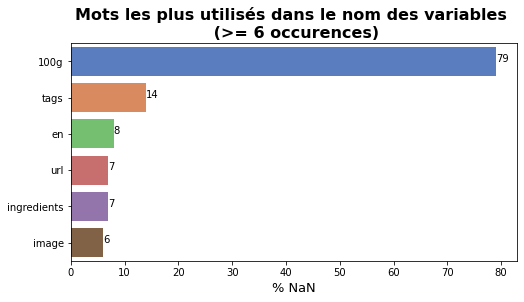

In [25]:
# Visualisation sous forme de barplot
plt.figure(figsize=(8, 4))
ax = sns.barplot(y = 'Mots', x = 'Nombre d\'occurences', data = most_common_columns_words, palette = 'muted')
plt.title("Mots les plus utilisés dans le nom des variables \n (>= 6 occurences)")
plt.ylabel("")
plt.xlabel("% NaN")
etiquette_h(ax);

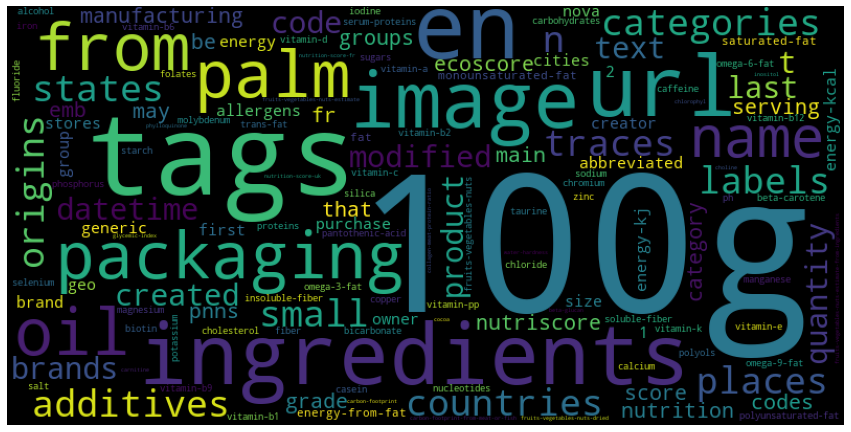

In [26]:
# Création d'un nuage de mots

# Conversion de la liste en dictionnaire valeurs / occurences
word_cloud_dict = Counter(liste_mots_colonnes_flat)
wordcloud = WordCloud(width = 800, height = 400).generate_from_frequencies(word_cloud_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off");

Nous allons analyser les variables qui ont le même préfixe afin de commencer à supprimer les variables qui apportent la même information. Ensuite, nous passerons en revue les autres variables afin de savoir lesquelles sélectionner dans notre dataset final. Lors de la sélection des variables, nous gardons en tête notre idée d'application. Ce passage en revue des différents variables va nous permettre de mieux connaitre le jeu de données et d'affiner notre projet en lien avec l'alimentation.

### 100g

Les variables qui se terminent par _100g correspondent à la quantité de nutriments (en g ou kj pour l'énergie) pour 100g ou 100 ml de produit. Logiquement ces variables devraient être de type float.

In [27]:
# Liste des colonnes qui se terminent par _100g
col_100g = openfoodfacts.iloc[:,openfoodfacts.columns.str.endswith('_100g')].columns.tolist()
print(col_100g)

['energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'starch_100g', 'polyols_100g', 'fiber_100g', 'soluble-fiber_100g', 'insoluble-fiber_100g', 'proteins_100g', 'casein_100g', 'serum-proteins_100g', 'nucleotides_100g', 'salt_100g', 'sodium_100g', 'alcohol_100g', 'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g', 'silica_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 'fluoride_100g', 'sele

In [28]:
# On downcast les variables en float32 pour réduire la mémoire
for col in col_100g:
    openfoodfacts[col] = openfoodfacts[col].astype('float32')

In [29]:
openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2053679 entries, 0 to 2053678
Columns: 148 entries, code to carnitine_100g
dtypes: float32(79), float64(7), int64(2), object(60)
memory usage: 1.7+ GB


In [30]:
# Dtypes des variables qui se terminent par _100g et qui ne sont pas de type float
openfoodfacts.iloc[:,openfoodfacts.columns.isin(col_100g)].select_dtypes(exclude = ['float32']).dtypes

Series([], dtype: object)

Toutes ces variables sont bien au format float. En regardant la liste des colonnes, on peut se demander si les variables energy-kj_100g et energy_100g apportent la même information.

In [31]:
openfoodfacts[openfoodfacts[['energy-kj_100g', 'energy-kcal_100g', 'energy_100g']].notnull().all(1)][
    ['energy-kj_100g', 'energy-kcal_100g', 'energy_100g']].head()

,energy-kj_100g,energy-kcal_100g,energy_100g
4,685.799988,163.899994,685.799988
417,2318.000000,561.000000,2318.000000
419,1104.000000,268.000000,1104.000000
790,442.000000,1852.000000,442.000000
863,1926.000000,460.000000,1926.000000


Les colonnes energy-kj_100g et energy_100g semblent être redondantes. Regardons la proportion de NaN.

In [32]:
print(f"% de NaN de la variable energy-kj_100g: {round(openfoodfacts['energy-kj_100g'].isna().mean(),4)*100}%")
print(f"% de NaN de la variable energy_100g: {round(openfoodfacts['energy_100g'].isna().mean(),4)*100}%")

% de NaN de la variable energy-kj_100g: 92.7%
% de NaN de la variable energy_100g: 20.66%


La variables energy_100g comporte bien moins de valeurs manquantes que energy-kj_100g. Nous allons remplir les NaN de energy_100g avec les éventuelles  valeurs renseignées de energy-kj_100g puis supprimer la colonne energy-kj_100g.

In [33]:
# Pour les NaN de energy_100g, je complète avec energy-kj_100g sinon je laisse tel quel
openfoodfacts['energy_100g'] = np.where(openfoodfacts['energy_100g'].isnull(), 
                                        openfoodfacts['energy-kj_100g'], 
                                        openfoodfacts['energy_100g'])

In [34]:
print(f"% de NaN de la variable energy_100g: {round(openfoodfacts['energy_100g'].isna().mean(),4)*100}%")

% de NaN de la variable energy_100g: 20.66%


La variable energy-kj_100g ne semble pas avoir diminué le taux de NaN de energy_100g, nous pouvons la supprimer.

In [35]:
openfoodfacts = openfoodfacts.drop('energy-kj_100g', 'columns')
openfoodfacts.shape

<ipython-input-35-112d0e192dab>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  openfoodfacts = openfoodfacts.drop('energy-kj_100g', 'columns')


(2053679, 147)

### tags

Les variables qui se terminent par _tags sont des variables qualitatives (packaging, marques, catégories etc). Elles doivent être de type "object".

In [36]:
# Liste des colonnes qui se terminent par _tags
col_tags = openfoodfacts.iloc[:,openfoodfacts.columns.str.endswith('_tags')].columns.tolist()
print(col_tags)

['packaging_tags', 'brands_tags', 'categories_tags', 'origins_tags', 'manufacturing_places_tags', 'labels_tags', 'emb_codes_tags', 'cities_tags', 'countries_tags', 'traces_tags', 'additives_tags', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags', 'states_tags']


In [37]:
# On cast les variables en str
for col in col_tags:
    openfoodfacts[col] = openfoodfacts[col].astype("object")

In [38]:
openfoodfacts.iloc[:,openfoodfacts.columns.isin(col_tags)].select_dtypes(exclude = ['object']).dtypes

Series([], dtype: object)

Toutes ces variables ont bien le dtype objet. A partir du préfixe des variables se terminant par _tags, tentons de récupérer les variables associées afin de s'assurer qu'elles ne sont pas redondantes. 

In [39]:
# Pour chaque colonne se terminant par _tags, je supprime cette mention pour n'avoir que le préfixe
liste_col_tags_prefixe = [i.replace('_tags', '') for i in openfoodfacts.iloc[
    :,openfoodfacts.columns.isin(col_tags)].columns.unique().tolist()]

print(f'Préfixes des colonnes se terminant par _tags: {liste_col_tags_prefixe}')

Préfixes des colonnes se terminant par _tags: ['packaging', 'brands', 'categories', 'origins', 'manufacturing_places', 'labels', 'emb_codes', 'cities', 'countries', 'traces', 'additives', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', 'states']


In [40]:
# Fusion des 2 listes + tri par ordre alphabétique
liste_col_tags = liste_col_tags_prefixe + col_tags
liste_col_tags.sort()

In [41]:
print(f'Colonnes + colonnes associées _tags:\n\n {liste_col_tags}')

Colonnes + colonnes associées _tags:

 ['additives', 'additives_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'cities', 'cities_tags', 'countries', 'countries_tags', 'emb_codes', 'emb_codes_tags', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'labels', 'labels_tags', 'manufacturing_places', 'manufacturing_places_tags', 'origins', 'origins_tags', 'packaging', 'packaging_tags', 'states', 'states_tags', 'traces', 'traces_tags']


Automatisation des étapes précédentes.

In [42]:
def liste_col_endswith(dataframe, keyword):
    ''' Fonction qui permet de récupérer le préfixe des colonnes se terminant par un mot clef et qui retourne une liste
    de ces variables et des variables associées qui contiennent le préfixe. L'objectif est de s'assurer que ces variables
    n'apportent pas la même information.'''
    
    liste_col_keyword_prefixe = [i.replace(f'_{keyword}', '') for i in dataframe.iloc[
    :,dataframe.columns.str.endswith(keyword)].columns.unique().tolist()]
    
    liste_col_ends_keyword = dataframe.iloc[:,(dataframe.columns.str.endswith(
    keyword))].columns.unique().tolist()
    
    liste_col_keyword = liste_col_keyword_prefixe + liste_col_ends_keyword
    liste_col_keyword.sort()
    
    return liste_col_keyword

In [43]:
liste_col_tags = liste_col_endswith(openfoodfacts, 'tags')

In [44]:
def describe_variables_light(data):
    '''Fonction qui prend un dataframe en entrée, et retourne un récapitulatif qui contient le nom des variables, 
    leur type, un exemple de modalité, le nombre total de lignes, le nombre et pourcentage de valeurs distinctes, 
    le nombre et pourcentage de valeurs non manquantes et de valeurs manquantes (NaN)'''

    # Choix du nom des variables à afficher
    df = pd.DataFrame(columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', '% distinct', 
                                 'Not NaN', '% Not NaN', 'NaN', '% NaN'])
    
    # Pour chaque colonne du dataframe
    for column in data.columns:
        
        # Définition des variables
        var_type = data[column].dtypes # type de la variable (object, float, int...)
        example = data[data[column].notna()][column].iloc[0] # premier élément notNA
        #example = [data[data[column].notna()][column].iloc[0] if data[column].isna().sum() != len(data[column]) else 0]
        nb_raw = len(data[column]) # nombre total de lignes
        count = len(data[column])- data[column].isna().sum() # nombre de valeurs non manquantes
        percent_count = round(data[column].notnull().mean(),4)*100 # % de valeurs non manquantes
        distinct = data[column].nunique() # nombre de modalités que peut prendre la variable
        percent_distinct = round(data[column].nunique()/len(data[column]),4)*100 # % de valeurs distinctes
        missing = data[column].isna().sum() # nombre de valeurs manquantes
        percent_missing = round(data[column].isna().mean(),4)*100 # % de valeurs manquantes
        
        
        df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count, 
                                      percent_count,missing, percent_missing]], 
                                    columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', 
                                               '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN']))
        
    return df.reset_index(drop = True)

In [45]:
describe_variables_light(openfoodfacts.iloc[:,openfoodfacts.columns.isin(liste_col_tags)])

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,packaging,object,"barquette,plastique",2053679,57066,2.78,315935,15.38,1737744,84.62
1,packaging_tags,object,"barquette,plastique",2053679,46485,2.26,315895,15.38,1737784,84.62
2,brands,object,endives,2053679,183520,8.94,1050597,51.16,1003082,48.84
3,brands_tags,object,endives,2053679,141427,6.89,1050528,51.15,1003151,48.85
4,categories,object,"Epicerie, Condiments, Sauces, Moutardes",2053679,117610,5.73,945149,46.02,1108530,53.98
5,categories_tags,object,"en:groceries,en:condiments,en:sauces,en:mustards",2053679,72803,3.55,945141,46.02,1108538,53.98
6,origins,object,Spain,2053679,14023,0.68,88290,4.30,1965389,95.70
7,origins_tags,object,en:spain,2053679,11428,0.56,88160,4.29,1965519,95.71
8,manufacturing_places,object,bénivay-ollon,2053679,28901,1.41,128424,6.25,1925255,93.75
9,manufacturing_places_tags,object,benivay-ollon,2053679,25973,1.26,128364,6.25,1925315,93.75


In [46]:
def completion_distinct_plots(data):
    ''' fonction qui prend un dataframe en entrée et retourne 2 diagrammes en barres représentant le pourcentage 
    de données manquantes et le pourcentage de données distinctes du dataset. Cette fonction nécessite que
    soit chargée auparavant la fonction describe_variables '''   
    
    # Initialisation de la grille avec 1 ligne et 2 colonnes
    fig = plt.figure(figsize=(15,7), constrained_layout=True)
    gs = GridSpec(nrows=1, ncols=2, figure=fig)

    # Premier graphique
    ax1 = fig.add_subplot(gs[0,0]) # emplacement dans la grille
    ax1 = sns.barplot(y = 'Variable name', x = '% NaN', data = describe_variables_light(data), palette = 'muted')
    plt.title("% NaN")
    plt.ylabel("")
    plt.xlabel("% NaN")
    etiquette_h(ax1)
        

# Deuxième graphique
    ax2 = fig.add_subplot(gs[0,1]) # emplacement dans la grille
    ax2 = sns.barplot(y = 'Variable name', x = '% distinct', data = describe_variables_light(data), palette = 'muted')
    plt.title("% valeurs distinctes")
    plt.ylabel("")
    plt.xlabel("% distinct")
    etiquette_h(ax2);

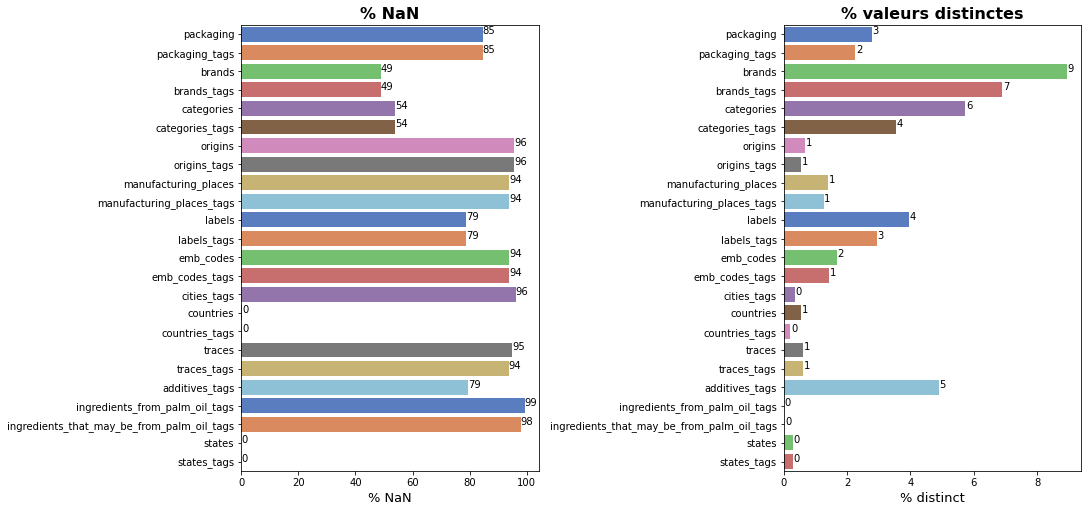

In [47]:
completion_distinct_plots(openfoodfacts.iloc[:,openfoodfacts.columns.isin(liste_col_tags)])

Nous remarquons que les variables se terminant par _tags comportent souvent le même % de NaN que la variable associée mais le % de valeurs distinctes est quant à lui inférieur. Il semble être plus intéressant de conserver les variables se terminant par _tags et de supprimer les variables associées afin d'éviter la redondance d'information. De plus le site openfoodfacts nous indique que les variables _tags sont normalisées. Regardons quelques exemples avant de supprimer toutes les variables associées à celles se terminant par _tags.

In [48]:
openfoodfacts[~openfoodfacts['brands'].isnull()][['brands', 'brands_tags']].sample(10)

,brands,brands_tags
1040897,La Compagnie Des Pruneaux,la-compagnie-des-pruneaux
1719872,Scopel,scopel
880782,Fleury michon,fleury-michon
1285441,BioBio,biobio
576304,Sondey,sondey
476134,Izze,izze
547584,GutBio,gutbio
413851,Sunny Select,sunny-select
851781,Picard,picard
1964600,Magnum,magnum


In [49]:
openfoodfacts[~openfoodfacts['categories'].isnull()][['categories', 'categories_tags']].sample(10)

,categories,categories_tags
403763,"Plant-based foods and beverages, Beverages, Plant-based beverages","en:plant-based-foods-and-beverages,en:beverages,en:plant-based-beverages"
1398922,"Aliments et boissons à base de végétaux, Boissons, Aliments d'origine végétale, Epicerie, Condiments, Plantes condimentaires, Boissons chaudes, Boissons à base de végétaux, Plantes aromatiques, Produits déshydratés, Herbes aromatiques, Aliments à base de plantes séchées, Infusions, Plantes aromatiques sèches moulues, Plantes en pot, Origan, Plantes aromatiques en pot, Origan séché moulu, Origan en pot, Boissons sans sucre ajouté, Aliments à base de plantes séchés","en:plant-based-foods-and-beverages,en:beverages,en:plant-based-foods,en:groceries,en:condiments,en:culinary-plants,en:hot-beverages,en:plant-based-beverages,en:aromatic-plants,en:dried-products,en:aromatic-herbs,en:dried-plant-based-foods,en:herbal-teas,en:ground-dried-aromatic-plants,en:potted-plants,en:oregano,en:potted-aromatic-plants,en:ground-dried-oregano,en:potted-oregano,en:unsweetened-beverages,fr:aliments-a-base-de-plantes-seches"
1999165,en:Rice-porridge,en:rice-porridge
76364,Salted snacks,en:salted-snacks
497636,"Snacks, Sweet snacks, Biscuits and cakes, Biscuits","en:snacks,en:sweet-snacks,en:biscuits-and-cakes,en:biscuits"
620250,"Carnes, Aves, Pollo","en:meats,en:poultries,en:chickens"
1427338,"Aliments et boissons à base de végétaux, Boissons, Aliments d'origine végétale, Céréales et pommes de terre, Céréales et dérivés, Boissons à base de végétaux, Substitut du lait, Boissons végétales, Boissons végétales de céréales, Boissons au sarrasin","en:plant-based-foods-and-beverages,en:beverages,en:plant-based-foods,en:cereals-and-potatoes,en:cereals-and-their-products,en:plant-based-beverages,en:milk-substitute,en:plant-milks,en:cereal-milks,en:buckwheat-milks"
1864022,"Leche semidesnatada,Leche de vaca","en:dairies,en:milks,en:semi-skimmed-milks,en:cow-milks"
715669,"Snacks, Snacks sucrés, Biscuits et gâteaux, Biscuits, Biscuits sablés, Sablés au beurre","en:snacks,en:sweet-snacks,en:biscuits-and-cakes,en:biscuits,en:shortbread-cookies,fr:sables-au-beurre"
614448,"Lácteos, Comidas fermentadas, Productos fermentados de la leche, Quesos, Quesos italianos, Parmigiano-Reggiano","en:dairies,en:fermented-foods,en:fermented-milk-products,en:cheeses,en:italian-cheeses,en:parmigiano-reggiano"


In [50]:
openfoodfacts[~openfoodfacts['labels'].isnull()][['labels', 'labels_tags']].sample(10)

,labels,labels_tags
156964,Organic,en:organic
1461683,Dansk,en:dansk
1919279,"Vegetarian, Vegan, Organic","en:organic,en:vegetarian,en:vegan"
961398,en:lait-francais-french-milk,en:lait-francais-french-milk
1197597,"Bio, EU-Öko-Verordnung, Nicht EU-Landwirtschaft, Biodynamische Landwirtschaft, DE-ÖKO-007, Demeter, EU-Landwirtschaft, EU-/Nicht-EU-Landwirtschaft","en:organic,en:eu-organic,en:non-eu-agriculture,en:biodynamic-agriculture,en:de-oko-007,en:demeter,en:eu-agriculture,en:eu-non-eu-agriculture"
1093838,"Bio, Bio européen, Commerce équitable, Agriculture non UE, AB Agriculture Biologique, FR-BIO-01, Point Vert, IT-BIO-014, Max Havelaar, Symbole des Producteurs Paysans (SPP)","en:organic,en:eu-organic,en:fair-trade,en:non-eu-agriculture,en:fr-bio-01,en:green-dot,en:it-bio-014,en:max-havelaar,fr:ab-agriculture-biologique,fr:symbole-des-producteurs-paysans-spp"
565169,Punto Verde,en:green-dot
500775,en:gluten-free,en:gluten-free
1183010,Point Vert,en:green-dot
1985530,"Végétarien, en:gluten-free","en:vegetarian,en:no-gluten"


Les variables semblent bien redondantes entre elles. Nous remarquons également que les variables se terminant par _tags semblent être le plus souvent traduites en anglais. Nous décidons de garder ces dernières.

In [51]:
liste_col_suppr = openfoodfacts.iloc[:,(openfoodfacts.columns.isin(liste_col_tags)) & 
                                        (~openfoodfacts.columns.str.endswith('_tags'))].columns.unique().tolist()
print(f"Liste des variables à supprimer: \n\n {liste_col_suppr}")

Liste des variables à supprimer: 

 ['packaging', 'brands', 'categories', 'origins', 'manufacturing_places', 'labels', 'emb_codes', 'countries', 'traces', 'states']


In [52]:
# Suppression des variables sans suffixe _tags
openfoodfacts_tags = openfoodfacts.drop(liste_col_suppr, axis = 'columns', inplace = False)

print(f"Nombre de lignes: {openfoodfacts_tags.shape[0]}\nNombre de variables: {openfoodfacts_tags.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 137


### en

La documentation nous indique que ces variables sont la traduction des variables _tags dans la langue indiquée. Elles doivent être de type "object".

In [53]:
# Liste des colonnes qui se terminent par _en
col_en = openfoodfacts_tags.iloc[:,openfoodfacts_tags.columns.str.endswith('_en')].columns.tolist()
print(col_en)

['categories_en', 'origins_en', 'labels_en', 'countries_en', 'traces_en', 'additives_en', 'states_en', 'main_category_en']


In [54]:
# On cast les variables en str
for col in col_en:
    openfoodfacts_tags[col] = openfoodfacts_tags[col].astype("object")

In [55]:
openfoodfacts_tags.iloc[:,openfoodfacts_tags.columns.isin(col_en)].select_dtypes(exclude = ['object']).dtypes

Series([], dtype: object)

In [56]:
print(liste_col_endswith(openfoodfacts_tags, 'en'))

['additives', 'additives_en', 'categories', 'categories_en', 'countries', 'countries_en', 'labels', 'labels_en', 'main_category', 'main_category_en', 'origins', 'origins_en', 'states', 'states_en', 'traces', 'traces_en']


On retrouve dans cette liste les préfixes des variables qui se terminent par _tags. Lorsque l'on applique la fonction précédente on ne récupère que le préfixe et la variable associée. Il faudrait en fait récupérer tous les préfixes et regarder les variables associées: _tags, _en etc. Améliorons la fonction.

In [57]:
def liste_col_prefixe(dataframe, keyword):
    ''' Fonction qui permet de récupérer le préfixe des colonnes se terminant par un mot clef et qui retourne une liste
    de ces variables et des variables associées qui contiennent le préfixe. L'objectif est de s'assurer que ces variables
    n'apportent pas la même information.'''
    
    liste_col_keyword_prefixe = [i.replace(f'_{keyword}', '') for i in dataframe.iloc[
    :,dataframe.columns.str.endswith(keyword)].columns.unique().tolist()]
    
    liste_col_select = dataframe.iloc[:, dataframe.columns.str.startswith(
        tuple(liste_col_keyword_prefixe))].columns.unique().tolist()
    
    liste_col_select.sort()
                                      
    return dataframe.iloc[:,dataframe.columns.isin(liste_col_select)].columns

In [58]:
liste_col_en = liste_col_prefixe(openfoodfacts_tags, 'en')

In [59]:
describe_variables_light(openfoodfacts_tags.iloc[:,openfoodfacts_tags.columns.isin(liste_col_en)])

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,categories_tags,object,"en:groceries,en:condiments,en:sauces,en:mustards",2053679,72803,3.55,945141,46.02,1108538,53.98
1,categories_en,object,"Groceries,Condiments,Sauces,Mustards",2053679,72800,3.54,945141,46.02,1108538,53.98
2,origins_tags,object,en:spain,2053679,11428,0.56,88160,4.29,1965519,95.71
3,origins_en,object,Spain,2053679,11389,0.55,88160,4.29,1965519,95.71
4,labels_tags,object,fr:delois-france,2053679,60380,2.94,438458,21.35,1615221,78.65
5,labels_en,object,fr:delois-france,2053679,60362,2.94,438458,21.35,1615221,78.65
6,countries_tags,object,en:france,2053679,4403,0.21,2047488,99.70,6191,0.30
7,countries_en,object,France,2053679,4403,0.21,2047488,99.70,6191,0.30
8,traces_tags,object,"en:eggs,en:milk",2053679,12766,0.62,129529,6.31,1924150,93.69
9,traces_en,object,"Eggs,Milk",2053679,12766,0.62,129529,6.31,1924150,93.69


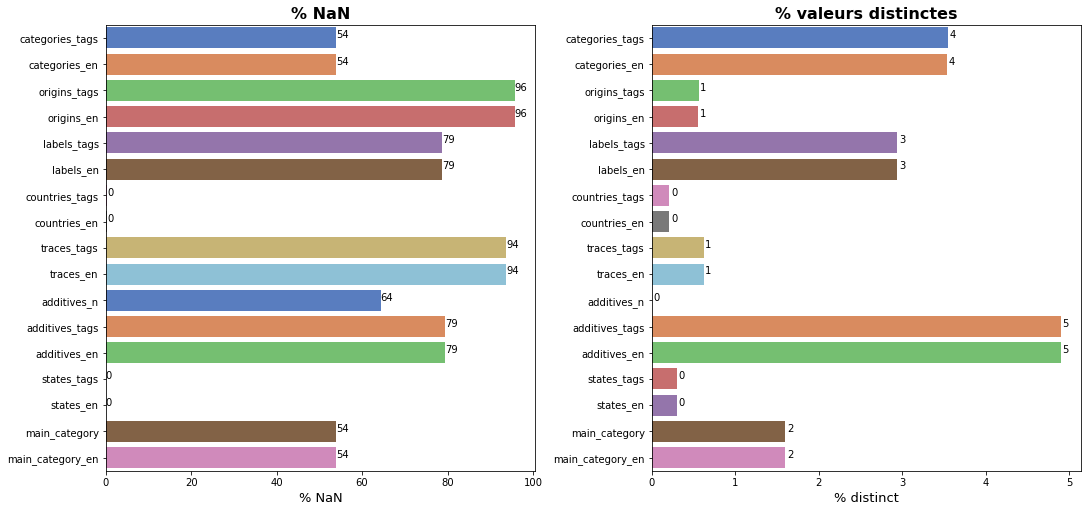

In [60]:
completion_distinct_plots(openfoodfacts_tags.iloc[:,openfoodfacts_tags.columns.isin(liste_col_en)])

Nous remarquons que les variables ayant le même préfixe comportent le même % de NaN et de valeurs distinctes. Comme nous avons déjà précedemment supprimé les variables sans suffixe, il nous reste les variables se terminant par _tags et _en. Nous avons donc le choix de conserver soit l'une soit l'autre. Vérifions juste un exemple avant de choisir quelles variables supprimer.

In [61]:
openfoodfacts_tags[~openfoodfacts_tags['categories_tags'].isnull()][['categories_tags', 'categories_en']].sample(10)

,categories_tags,categories_en
227960,en:salted-snacks,Salted-snacks
543613,"en:meats,en:prepared-meats,en:sausages,en:cervelat","Meats,Prepared meats,Sausages,Cervelat"
896823,"en:plant-based-foods-and-beverages,en:plant-based-foods,en:fruits-and-vegetables-based-foods,en:meals,en:soups,en:cream-soups,en:vegetable-soups,en:cream-of-vegetable-soups","Plant-based foods and beverages,Plant-based foods,Fruits and vegetables based foods,Meals,Soups,Cream soups,Vegetable soups,Cream of vegetable soups"
1533525,"en:plant-based-foods-and-beverages,en:plant-based-foods,en:fats,en:spreads,en:salted-spreads,en:spreadable-fats,en:vegetable-fats,en:plant-based-spreads,en:margarines","Plant-based foods and beverages,Plant-based foods,Fats,Spreads,Salted spreads,Spreadable fats,Vegetable fats,Plant-based spreads,Margarines"
269725,en:salted-snacks,Salted-snacks
429641,"en:plant-based-foods-and-beverages,en:plant-based-foods,en:fruits-and-vegetables-based-foods,en:frozen-foods,en:vegetables-based-foods,en:frozen-plant-based-foods,en:frozen-vegetables,en:leaf-vegetables,en:cauliflowers,en:frozen-cauliflower-florets","Plant-based foods and beverages,Plant-based foods,Fruits and vegetables based foods,Frozen foods,Vegetables based foods,Frozen plant-based foods,Frozen vegetables,Leaf vegetables,Cauliflowers,Frozen cauliflower florets"
333132,"en:pies,en:sweet-pies,en:fruit-tarts,en:pear-pies","Pies,Sweet pies,Fruit tarts,Pear pies"
25187,"en:meals,en:stews","Meals,Stews"
1943797,"en:dairies,en:fermented-foods,en:fermented-milk-products,en:yogurts","Dairies,Fermented foods,Fermented milk products,Yogurts"
1641923,"en:dairies,en:milks,en:homogenized-milks,en:goat-milks,en:uht-milks","Dairies,Milks,Homogenized milks,Goat milks,UHT Milks"


Les modalités étant plus lisibles et harmonisées dans les colonnes se terminant par _en, supprimons les colonnes _tags.

In [62]:
liste_col_suppr = openfoodfacts_tags.iloc[:,(openfoodfacts_tags.columns.isin(liste_col_en)) & 
                                        (openfoodfacts_tags.columns.str.endswith('_tags'))].columns.unique().tolist()
print(f"Liste des variables à supprimer: \n\n {liste_col_suppr}")

Liste des variables à supprimer: 

 ['categories_tags', 'origins_tags', 'labels_tags', 'countries_tags', 'traces_tags', 'additives_tags', 'states_tags']


In [63]:
# Suppression des variables avec suffixe _tags
openfoodfacts_en = openfoodfacts_tags.drop(liste_col_suppr, axis = 'columns', inplace = False)

print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 130


### url / image

Ces variables indiquent les urls et les images des produits et n'apportent aucune information. Supprimons les.

In [64]:
liste_col_url = openfoodfacts_en.iloc[:,openfoodfacts_en.columns.str.contains('url|image')].columns.unique().tolist()
print(f"Liste des variables url à supprimer: \n\n {liste_col_url}")

Liste des variables url à supprimer: 

 ['url', 'image_url', 'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url']


In [65]:
# Suppression des variables contenant les mot url ou image
openfoodfacts_en.drop(liste_col_url, axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 123


### ingredients

In [66]:
def check_redundancy(dataframe, keyword):
    ''' Fonction qui renseigne sur les principales statistiques des variables contenant le mot saisi en entrée.'''
    liste = dataframe.iloc[:,dataframe.columns.str.contains(keyword)].columns.unique().tolist()
    describe = describe_variables_light(dataframe[liste])
    return describe

In [67]:
def modalities_no_NaN(dataframe, keyword):
    ''' Fonction qui renvoie 5 exemples non nuls des variables contenant le mot saisi en entrée'''
    liste_col = check_redundancy(dataframe, keyword)['Variable name'].tolist()
    return dataframe[dataframe[liste_col].notnull().all(1)][liste_col].sample(5)

In [68]:
def check_redundancy_steps(dataframe, mot_clef):
    ''' Fonction qui renvoie 2 dataframes: 
    tab_desc qui renseigne sur les principales  statistiques des variables contenant le mot saisi en entrée
    tab_modalities qui renvoie 5 exemples non nuls des variables contenant le mot saisi en entrée'''
    tab_desc = check_redundancy(dataframe, mot_clef)
    tab_modalities = modalities_no_NaN(dataframe, mot_clef)
    return tab_desc, tab_modalities

In [69]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'ingredients')

In [70]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,ingredients_text,object,"Leche semidesnatada, azucar 6.9% leche desnatada en polva, fermentos lacticos (contiene Lactobacidus casei), vitaminas (B6 y D).",2053679,616705,30.03,732671,35.68,1321008,64.32
1,ingredients_from_palm_oil_n,float64,0.0,2053679,4,0.00,732673,35.68,1321006,64.32
2,ingredients_from_palm_oil_tags,object,huile-de-palme,2053679,16,0.00,14505,0.71,2039174,99.29
3,ingredients_that_may_be_from_palm_oil_n,float64,0.0,2053679,7,0.00,732673,35.68,1321006,64.32
4,ingredients_that_may_be_from_palm_oil_tags,object,"e481-stearoyl-2-lactylate-de-sodium,e472e-ester-monoacethyltartrique-de-mono-et-diglycerides-d-acides-gras,e472b-ester-diacetyl-lactique-de-mono-et-diglycerides-d-acides-gras",2053679,350,0.02,43295,2.11,2010384,97.89
5,fruits-vegetables-nuts-estimate-from-ingredients_100g,float32,0.0,2053679,7644,0.37,731230,35.61,1322449,64.39


In [71]:
tab_modalities

,ingredients_text,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,fruits-vegetables-nuts-estimate-from-ingredients_100g
1963876,"Huiles végétales 50% (tournesol, colza, palme, lin), eau, émulsifiants : lécithine de tournesol, mono- et diglycérides d'acides gras, sel 0,3%, amidon modifié, conservateur : sorbate de potassium, correcteur d'acidité : acide citrique, arômes, vitamines A et D, colorant : caroténoïdes",1.0,huile-de-palme,1.0,e471-mono-et-diglycerides-d-acides-gras-alimentaires,0.0
753858,"!ngredients : Chocolat au lait (e,ucre, beurre de cacao, lait poudre, péte de cacao, lactose* , lactosérum* en poudre, émulsifiant : lécithine de soja), praliné (sucre, amandes, noisettes), sucre, chocolat noir (pâte de cacao, sucre, beurre* concentré, beurre de cacao, émulsifiant : lécithine de soja), pâte de cacao, beurre de cacao, graisses végétales (palme et palmiste), lait entier en poudre, pâte de figues avec akènes, chocolat noir origine Madagascar (fèves de cacao de Madagascar, sucre, beurre de cacao, émulsifiant . lécithine de soja), beurre* concentré, lactosérum* en poudre, crème* stérilisée, lactose*, lait concentré écrémé sucré, sirop de glucose, huile de tournesol, sirop de sucre inverti, grains d'amandes torréfiés, éclats de crêpe dentelle (farine de blé, sucre, beurre* concentré, huile de tournesol, lait écrémé en poudre, malt d'orge, sel), grains de nougatine (sucre, noisettes torréfiées et noisettes partiellement déshuilées torréfiées), céréales (farine de riz, sucre, gluten de blé, huile de palme, malt de blé, sel), humectant : sorbitol, cacao maigre en poudre, émulsifiants : monostéarate de glycérol, lécithine de soja, arômes, fleur de sel de Guérande, enzyme : iruertase, sel, extrait de vanille, blanc d'oeuf, amidon de blé, farine de blé malté, fibres végétales, poudre à lever : E 500ii , café, épices. Contient lait* , soja, amande, noisette, blé, orge et oeuf Présence possible d'arachide, noix, noix de cajou, noix de pécan et pistache.",1.0,huile-de-palme,1.0,monostearate-de-glycerol,0.0
1038019,"Pâte 68,2% : farine de blé - eau huile végétale non hydrogénée (palme) - beurre 3,3% - sucre - levure - sel - émulsifiants : E471, E472e - dextrose (blé) - gluten (blé) - poudre à lever : E 450ii, E 500i - stabilisant (E 412) - Fourrage 28,4 0% : sucre - huile végétale (colza) - noisettes (10%) - cacao maigre en poudre (6%) - lait écrémé en poudre - lactose - émulsifiant : E322 (tournesol). Glaçage 3,4% : sucre (75%) - eau - graisse végétale non hydrogénée (palme) - sirop de glucose (blé) - épaississant : E415 - arôme.",1.0,huile-de-palme,2.0,"e471-mono-et-diglycerides-d-acides-gras-alimentaires,e472e-ester-monoacethyltartrique-de-mono-et-diglycerides-d-acides-gras",10.0
676687,"semoule de riz 71 chocolat en poudre 21 ,4% (sucre, cacao en poudre), sirop de glucose, sucre, sel, émulsifiant (mono - et diglycérides d'acides gras (palme)), arôme. Traces éventuelles de fruits à coque, de lait et de soja.",1.0,huile-de-palme,1.0,e471-mono-et-diglycerides-d-acides-gras-alimentaires,0.0
1042013,"Sirop de glucose, lait écrémé concentré sucré, sucre, huile de palme, cacao maigre en poudre, sel, émulsifiants (E471, lécithine de tournesol), arômes. Peut contenir fruits à coque.",1.0,huile-de-palme,1.0,e471-mono-et-diglycerides-d-acides-gras-alimentaires,0.0


Nous pouvons remarquer que la variable ingredients_text contient un grand nombre de modalités et 64.32% de valeurs manquantes. 

Nous pouvons également voir que 4 variables comportent la mention palm_oil dont 2 variables qui se terminent par _n indiquent le nombre d'ingrédients contenant de l'huile de palme. 

Les 2 variables ingredients_from_palm_oil_tags et ingredients_that_may_be_from_palm_oil_tags ont un pourcentage très élevé de valeurs manquantes et semblent redondantes avec les variables numériques, qui si supérieures à 0, indiquent la présence d'huile de palme ou assimilé. Nous décidons de les supprimer.

In [72]:
# Suppression des variables ingredients_from_palm_oil_tags et ingredients_that_may_be_from_palm_oil_tags
openfoodfacts_en.drop(['ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags'],
                        axis = 'columns',
                        inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 121


## Autres variables <a class="anchor" id="misc"></a>

La nomenclature des variables nous donne d'autres informations. Elle se trouve à l'adresse: https://static.openfoodfacts.org/data/data-fields.txt

### Variables de localisation <a class="anchor" id="localisation"></a>

#### places

In [74]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'places')

In [75]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,manufacturing_places_tags,object,benivay-ollon,2053679,25973,1.26,128364,6.25,1925315,93.75
1,purchase_places,object,France,2053679,11361,0.55,161431,7.86,1892248,92.14


In [76]:
tab_modalities

,manufacturing_places_tags,purchase_places
1162469,"bad-zwischenahn,niedersachsen,deutschland","Bayreuth,Bayern,Deutschland"
1577425,jowa-ag-erlenwiesenstrasse-8604-volketswil-suisse,Suisse
803316,"zhejiang,chine","Flesselles,France"
1599265,argentina,Argentina
1531618,"mexico,yucatan,merida","Mexico,Yucatan,Merida"


Ces variables étant très peu alimentées (plus de 90% de NaN), supprimons les.

In [77]:
# Suppression des variables
openfoodfacts_en.drop(tab_modalities.columns, axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 119


#### countries_en

In [79]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'countries_en')

In [80]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,countries_en,object,France,2053679,4403,0.21,2047488,99.7,6191,0.3


In [81]:
tab_modalities

,countries_en
1259274,Germany
1494154,Algeria
662040,France
35248,United States
762760,France


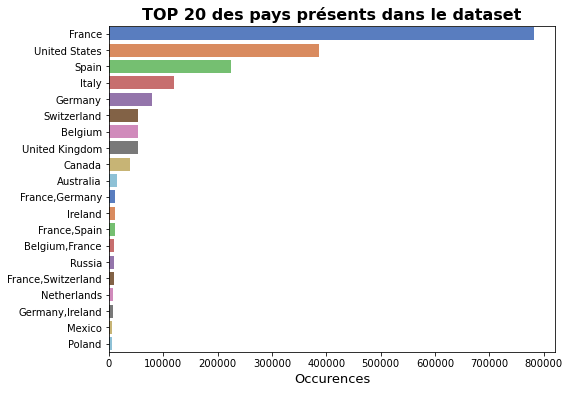

In [82]:
countries_en_count = openfoodfacts_en['countries_en'].value_counts()[0:20]

plt.figure(figsize=(8, 6))
sns.barplot(y = countries_en_count.index, x = countries_en_count.values, palette = 'muted')
plt.title("TOP 20 des pays présents dans le dataset")
plt.ylabel("")
plt.xlabel("Occurences");

On remarque que la France est en tête du classement suivie des Etats Unis et de l'Espagne. Cette variable ne contient que 0.3% de valeurs manquantes et 4 403 valeurs distinctes: la variable countries_en ne contient pas forcément un seul pays mais peut également contenir une liste de pays. On peut se poser la question de savoir si la France peut être traduite dans une autre langue:

In [83]:
openfoodfacts_en[(~openfoodfacts_en['countries_en'].str.contains(
    'France', na = False)) & (openfoodfacts_en['countries_en'].str.contains(
    'Fr', na = False))]['countries_en'].unique().tolist()

['Austria,Frankreich,Spanien',
 'French Polynesia,United States',
 'French Polynesia',
 'Mexico,Thailand,United States,Francia',
 'Kuwait,Spain,Francia',
 'Spain,Francia',
 'French Guiana',
 'Mexico,Spain,United States,Francia',
 'Mexico,Spain,Estados-unidos,Francia',
 'Spain,Estados-unidos,Francia',
 'Germany,Frankreich',
 'Austria,Frankreich',
 'Canada,French Polynesia',
 'Italy,Spain,Francia,Marruecos,Reino-unido',
 'American Samoa,Australia,Austria,Azerbaijan,Democratic Republic of the Congo,French Southern and Antarctic Lands',
 'Andorra,Portugal,Spain,Francia',
 'Portugal,Deutschland,Frankreich,Niederlande,Spanien',
 'Belgica,Francia',
 'Frankreich',
 'Francja,Niemcy,Polska,Szwajcaria',
 'Spain,Eslovenia,Francia',
 'Germany,Italy,Francia,Germania,Svizzera',
 'Spain,Alemania,Francia',
 'Francia-espana',
 'Spain,Francia,Suecia,Suiza',
 'Germany,Frankreich,Irland',
 'Italy,Spain,Alemania,Belgica,Francia,Suiza',
 'Germany,Portugal,Frankreich',
 'Austria,Germany,Frankreich,Schweiz',
 

On remarque que les pays peuvent apparaitre dans plusieurs langues. Quelques exemples pour la France:
- Frankreich
- French
- Francia
- Francja
- Frankrijk
- Franța
- Franca

On apprend sur le site https://www.economie.gouv.fr/dgccrf/Publications/Vie-pratique/Fiches-pratiques/Etiquetage-des-denrees-alimentaires que les étiquettes doivent être traduites au moins en français pour les produits vendus en France. Gardons cela en tête pour la suite du nettoyage.

### Variables sur le packaging <a class="anchor" id="packaging"></a>

Ces variables ne seront a priori pas utilisées par la suite, supprimons les mais regardons d'abord quelques exemples.

In [89]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'packaging')

In [90]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,packaging_tags,object,"barquette,plastique",2053679,46485,2.26,315895,15.38,1737784,84.62
1,packaging_text,object,1 pot en verre à recycler,2053679,4306,0.21,8240,0.40,2045439,99.60
2,first_packaging_code_geo,object,"47.833333,-0.333333",2053679,3768,0.18,73908,3.60,1979771,96.40


In [91]:
tab_modalities

,packaging_tags,packaging_text,first_packaging_code_geo
1104510,"boite,carton,cellulose,fr-boite-en-carton",1 étiquette papier à recycler. 1 boîte carton (cellulose) à recycler ou à composter (attestée par le label OK COMPOST et climatiquement neutre attestée par le label ClimatePartner).,"46,5.166667"
772526,"barquette,plastique",tri,"47.066667,-0.883333"
823578,sachet-en-plastique,1 sachet en plastique à jeter.,"47.083333,2.4"
808196,"barquette,plastique",1 barquette plastique 1 film plastique,"47.4,6.516667"
1063417,boite-cellulose,1 boite en papier à recycler 1 étiquette en papier à recycler,"48.866667,-1.033333"


Ces variables étant assez peu alimentées et non pertinentes pour notre idée d'application, supprimons les.

In [92]:
# Suppression des variables contenant le mot packaging
openfoodfacts_en.drop(tab_modalities.columns, axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 116


### Variables sur la marque <a class="anchor" id="brand"></a>

In [96]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'brand')

In [97]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,brands_tags,object,endives,2053679,141427,6.89,1050528,51.15,1003151,48.85
1,brand_owner,object,LAGG'S,2053679,25576,1.25,290020,14.12,1763659,85.88


In [98]:
tab_modalities

,brands_tags,brand_owner
44640,signature-select,"Safeway, Inc."
418719,"clif,clif-bar-and-company",Clif Bar and Company
425137,grand-prix-trading-corp,Grand Prix Trading Corp.
423623,country-choice,Country Choice Organic
524409,connie-s-pizza,"Connie's Naturals, LLC"


La variable brands_tags comporte bien moins de valeurs manquantes que brand_owner même si elle a plus de valeurs distinctes. Nous décidons de conserver brands_tags.

In [99]:
# Suppression de la variable brand_owner
openfoodfacts_en.drop('brand_owner', axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 115


### Variables sur le nom des produits <a class="anchor" id="name"></a>

In [100]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'name')

In [101]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,product_name,object,jeunes pousses,2053679,1276058,62.14,1970360,95.94,83319,4.06
1,abbreviated_product_name,object,Amora Moutarde Strong 6x2.5Kg 1x,2053679,7073,0.34,7197,0.35,2046482,99.65
2,generic_name,object,Blanquette de Volaille et son Riz,2053679,89427,4.35,123512,6.01,1930167,93.99


In [102]:
tab_modalities

,product_name,abbreviated_product_name,generic_name
746134,1664 25 cl,25 cl 1664,Bière premium
1119407,The imperial gunpowder vert chine bibal 1x25 - carton,The imperial gunpowder vert chine,The imperial gunpowder vert chine bibal 1x25 - carton
727739,Compote Recette Costa Rica Sans Sucres Ajoutés,PP RDM SSA POM MANGUE PAPAYE 4x90g,Spécialité de pomme mangue papaye avec arômes naturels sans sucres ajoutés (contient des sucres naturellement présents)
1043548,Beurre d'arachide Sucré,Beurre d'arachide Sucré Taza 350g,Beurre d'arachide Sucré
735230,Panzani tomacouli ail et fines herbes,Pz tomacouli afh 500 pav12,Purée de tomates fraîches reduite à 7% aromatisée à l'ail et aux fines herbes


Ces trois variables nous apportent la même information. abbreviated_product_name et generic_name ayant un fort pourcentage de valeurs manquantes, nous décidons de supprimer ces 2 variables.

In [103]:
# Suppression des variables abbreviated_product_name et generic_name
openfoodfacts_en.drop(['abbreviated_product_name', 'generic_name'], axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 113


### Variables sur les additifs <a class="anchor" id="additives"></a>

In [104]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'additives')

In [105]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,additives_n,float64,0.0,2053679,40,0.0,732673,35.68,1321006,64.32
1,additives_en,object,"E296 - Malic acid,E330 - Citric acid,E552 - Calcium silicate,E950 - Acesulfame k,E955 - Sucralose",2053679,100577,4.9,423384,20.62,1630295,79.38


In [106]:
tab_modalities

,additives_n,additives_en
50907,17.0,"E102 - Tartrazine,E110 - Sunset yellow FCF,E127 - Erythrosine,E129 - Allura red ac,E132 - Indigotine,E133 - Brilliant blue FCF,E322 - Lecithins,E322i - Lecithin,E330 - Citric acid,E338 - Phosphoric acid,E341 - Calcium phosphates,E341i - Monocalcium phosphate,E412 - Guar gum,E435 - Polyoxyethylene sorbitan monostearate,E450 - Diphosphates,E450i - Disodium diphosphate,E471 - Mono- and diglycerides of fatty acids,E475 - Polyglycerol esters of fatty acids,E500 - Sodium carbonates,E500ii - Sodium hydrogen carbonate,E903 - Carnauba wax"
1563718,1.0,"E322 - Lecithins,E322i - Lecithin"
381161,1.0,E414 - Acacia gum
223185,1.0,E330 - Citric acid
81967,4.0,"E202 - Potassium sorbate,E415 - Xanthan gum,E435 - Polyoxyethylene sorbitan monostearate,E471 - Mono- and diglycerides of fatty acids"


Le pourcentage de valeurs manquantes étant "acceptable", nous décidons de conserver ces variables pour le moment.

### Variables sur les dates <a class="anchor" id="dates"></a>

In [107]:
# Colonnes dont le titre se termine par "_t" ou "_datetime"
print("Liste des variables dont le titre se termine par _t ou _datetime: ")
liste_col_date = openfoodfacts_en.iloc[:,(openfoodfacts_en.columns.str.endswith('_datetime')) |
                   (openfoodfacts_en.columns.str.endswith('_t'))].columns.tolist()
liste_col_date

Liste des variables dont le titre se termine par _t ou _datetime: 


['created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime']

In [108]:
# Passage au bon format
from datetime import datetime
import time

for column in liste_col_date:
    if column.endswith('_t'):
        openfoodfacts_en[column] = pd.to_datetime(openfoodfacts_en[column], unit='s')
    else:
        openfoodfacts_en[column] = pd.to_datetime(openfoodfacts_en[column], format="%Y-%m-%d %H:%M:%S.%f", utc=True)

In [109]:
openfoodfacts_en[liste_col_date].head()

,created_t,created_datetime,last_modified_t,last_modified_datetime
0,2021-06-16 14:53:28,2021-06-16 14:53:28+00:00,2021-06-16 14:53:29,2021-06-16 14:53:29+00:00
1,2021-09-01 08:11:51,2021-09-01 08:11:51+00:00,2021-09-01 08:14:24,2021-09-01 08:14:24+00:00
2,2018-06-15 10:38:00,2018-06-15 10:38:00+00:00,2019-06-25 11:55:18,2019-06-25 11:55:18+00:00
3,2018-10-13 21:06:14,2018-10-13 21:06:14+00:00,2018-10-13 21:06:57,2018-10-13 21:06:57+00:00
4,2019-11-19 15:02:16,2019-11-19 15:02:16+00:00,2021-06-22 19:39:25,2021-06-22 19:39:25+00:00


On remarque de la redondance d'information, on supprime les variables qui se terminent par _datetime.

In [110]:
# Suppression des variables redondantes
openfoodfacts_en.drop(['created_datetime', 'last_modified_datetime'], axis=1, inplace = True)

In [111]:
# On renomme les variables de date
openfoodfacts_en.rename(columns={'created_t': 'creation_date', 
                              'last_modified_t': 'last_modified_date'}, inplace = True)

In [ ]:
# On créé des variables "Année"
#openfoodfacts_en['creation_year'] = pd.to_datetime(openfoodfacts_en['creation_date'], format='%d:%m:%Y').dt.year
#openfoodfacts_en['last_modified_year'] = pd.to_datetime(openfoodfacts_en['last_modified_date'], format='%d:%m:%Y').dt.year

In [ ]:
# On décale les colonnes "Année" après les colonnes de date:
#colonne_a_decaler = openfoodfacts_en.pop('creation_year') 
#openfoodfacts_en.insert(openfoodfacts_en.columns.get_loc("creation_date")+1, 'creation_year', colonne_a_decaler) 

#colonne_a_decaler = openfoodfacts_en.pop('last_modified_year') 
#openfoodfacts_en.insert(openfoodfacts_en.columns.get_loc("last_modified_date")+1, 'last_modified_year', colonne_a_decaler) 

In [ ]:
#openfoodfacts_en.dtypes[0:10]

### Variables sur les portions <a class="anchor" id="serving"></a>

Les variables qui commencent par serving_ correspondent au nombre de nutriments (en g, ou kj pour l'énergie) pour une part du produit. Elles doivent être de type numérique.

In [112]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'serving')

In [113]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,serving_size,object,serving,2053679,47101,2.29,509794,24.82,1543885,75.18
1,serving_quantity,float64,28.0,2053679,2456,0.12,505560,24.62,1548119,75.38


In [114]:
tab_modalities

,serving_size,serving_quantity
90313,2 Tbsp (33 g),33.0
767129,125 g,125.0
411394,1 BAG (28.4 g),28.4
1778907,120g,120.0
125861,2 COOKIES (31 g),31.0


Ces 2 colonnes semblent être redondantes. Le % de NaN étant assez similaire et la variable serving_quantity déjà au format numérique, supprimons la variable serving_size.

In [115]:
# Suppression de la variable serving_size
openfoodfacts_en.drop('serving_size', axis = 'columns', inplace = True)

print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 110


### Variables sur les labels <a class="anchor" id="labels"></a>

In [116]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'labels')

In [117]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,labels_en,object,fr:delois-france,2053679,60362,2.94,438458,21.35,1615221,78.65


In [118]:
tab_modalities

,labels_en
624751,"Organic,EU Organic,FR-BIO-01"
160925,"New,No colorings"
1620842,PGI
743514,"Low Sodium,de:fur-babynahrung-geeignet"
18712,Organic


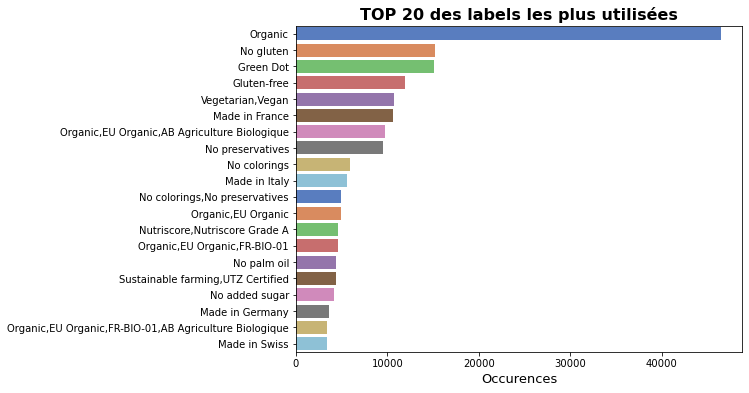

In [119]:
labels_en_count = openfoodfacts_en['labels_en'].value_counts()[0:20]

plt.figure(figsize=(8, 6))
sns.barplot(y = labels_en_count.index, x = labels_en_count.values, palette = 'muted')
plt.title("TOP 20 des labels les plus utilisées")
plt.ylabel("")
plt.xlabel("Occurences");

Gardons cette variable qui permet notamment de savoir si le produit provient de l'agriculture biologique par exemple.

### Variables sur les scores <a class="anchor" id="scores"></a>

#### Nutriscore

Le nutriscore est attribué sur la base d’un score prenant en compte pour 100 gr ou 100 mL de produit, la teneur :

- en nutriments et aliments à favoriser (fibres, protéines, fruits, légumes, légumineuses, fruits à coques, huile de colza, de noix et d’olive),
- et en nutriments à limiter (énergie, acides gras saturés, sucres, sel)

Après calcul, le score obtenu par un produit permet de lui attribuer une lettre et une couleur.

In [120]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'nutriscore')

In [121]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,nutriscore_score,float64,18.0,2053679,56,0.0,730959,35.59,1322720,64.41
1,nutriscore_grade,object,d,2053679,5,0.0,730959,35.59,1322720,64.41


In [122]:
tab_modalities

,nutriscore_score,nutriscore_grade
432126,1.0,b
12366,3.0,c
682343,5.0,c
1256610,-4.0,a
515330,22.0,e


Il parait plus pertinent de conserver le nutriscore_grade qui figure sur les produits. Le nutriscore_score permet juste d'associer le produit à une lettre en fonction de son score.

In [123]:
# Suppression de la variable nutriscore_score
openfoodfacts_en.drop('nutriscore_score', axis='columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 109


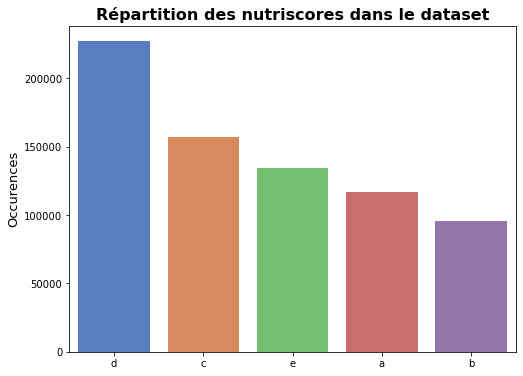

In [124]:
nutriscore_count = openfoodfacts_en['nutriscore_grade'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x = nutriscore_count.index, y = nutriscore_count.values, palette = 'muted')
plt.title("Répartition des nutriscores dans le dataset")
plt.ylabel("Occurences")
plt.xlabel("");

Les produits les plus mal notés semblent être ceux qui sont le plus représentés.

#### Groupe Nova

Les groupes Nova correspondent à une classification en 4 groupes selon le degré de transformation des aliments.
- Groupe 1 - Aliments non transformés ou transformés minimalement
- Groupe 2 - Ingrédients culinaires transformés
- Groupe 3 - Aliments transformés
- Groupe 4 - Produits alimentaires et boissons ultra-transformés

De nouvelles recherches de chercheurs de l'Inserm, de l'Inra et de l'Université Paris 13 (EREN) suggèrent une corrélation entre la consommation d'aliments ultra-transformés et un risque accru de développer un cancer.

In [125]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'nova_group')

In [126]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,nova_group,float64,4.0,2053679,4,0.0,640096,31.17,1413583,68.83


In [131]:
# Transformons cette variable en int
col = np.array(openfoodfacts_en['nova_group'], np.int8) # conversion en numpy array

openfoodfacts_en['nova_group'] = col # remplacement de nova group par le numpy array

In [132]:
# On remplace les 0 par NaN
openfoodfacts_en.loc[openfoodfacts_en['nova_group'] == 0, 'nova_group'] = np.nan

In [138]:
# On rajoute Group devant le numéro
openfoodfacts_en['nova_group'] = [f'Group {i}' for i in openfoodfacts_en['nova_group']]

In [150]:
# On enlève le .0 qui apparait après le nombre
openfoodfacts_en['nova_group'] = [str(i).replace('.0', '') for i in openfoodfacts_en['nova_group']]

In [151]:
# On transforme Group nan en np.nan
openfoodfacts_en.loc[openfoodfacts_en['nova_group'] == 'Group nan', 'nova_group'] = np.nan

In [168]:
# Fréquence de nova group dans le dataset
nova_percent = openfoodfacts_en[openfoodfacts_en['nova_group'] != 'nan'][
    'nova_group'].value_counts(normalize=True) * 100

In [170]:
data = nova_percent.values
labels = nova_percent.index

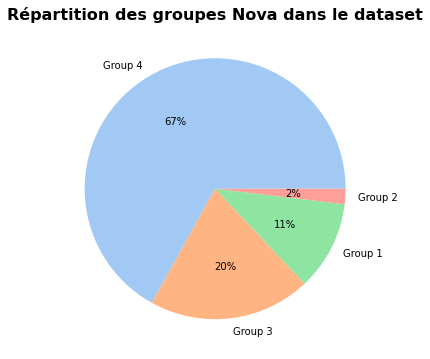

In [172]:
colors = sns.color_palette('pastel')[0:4]

plt.figure(figsize=(8, 6))
plt.title("Répartition des groupes Nova dans le dataset")
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%');

De la même manière que le nutriscore, les produits les plus transformés sont les plus représentés dans le dataset.

#### Ecoscore

L'Eco-Score est un score écologique (écoscore) de A à E qui permet de comparer facilement l'impact des produits alimentaires sur l'environnement. Pour chaque catégorie de produits, un score de référence est établi grâce aux données de la base environnementale Agribalyse conçue par l’ADEME et l’INRAE. Ces données correspondent à l’analyse de cycle de vie (ACV) des produits.

In [173]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'ecoscore')

In [174]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,ecoscore_score_fr,float64,34.0,2053679,9,0.0,10,0.0,2053669,100.0
1,ecoscore_grade_fr,object,d,2053679,5,0.0,10,0.0,2053669,100.0


On retrouve seulement 10 valeurs renseignées pour les variables ecoscore. Nous les supprimons.

In [176]:
# Suppression des variables
openfoodfacts_en.drop(['ecoscore_score_fr', 'ecoscore_grade_fr'], axis='columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 108


### Variables sur les catégories de produits <a class="anchor" id="categ"></a>

#### Categories

In [181]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'categ')

In [182]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,categories_en,object,"Groceries,Condiments,Sauces,Mustards",2053679,72800,3.54,945141,46.02,1108538,53.98
1,main_category,object,en:mustards,2053679,32887,1.60,945141,46.02,1108538,53.98
2,main_category_en,object,Mustards,2053679,32885,1.60,945141,46.02,1108538,53.98


In [183]:
tab_modalities

,categories_en,main_category,main_category_en
249564,"Plant-based foods and beverages,Plant-based foods,Fruits and vegetables based foods",en:fruits-and-vegetables-based-foods,Fruits and vegetables based foods
1032382,"Biscuits and cakes,Cakes,Muffins,Fruit muffins",en:fruit-muffins,Fruit muffins
971216,"Snacks,Sweet snacks,Frozen foods,Biscuits and cakes,Biscuits,Shortbread cookies",en:shortbread-cookies,Shortbread cookies
302925,"Dairies,Fermented foods,Fermented milk products,Cheeses,Cow cheeses,French cheeses,Uncooked pressed cheeses,Morbier",en:morbier,Morbier
1072568,"Snacks,Sweet snacks,Confectioneries,Nougats",en:nougats,Nougats


Ces 3 variables nous apportent la même information avec plus ou moins de détail. On note que les variables main_category sont égales au dernier élément de la liste categories_en. Le pourcentage de valeurs manquantes étant le même, notre critère de sélection sera porté sur le pourcentage de valeurs distinctes. Parmi les 2 variables avec le taux de valeurs distinctes le plus bas, nous décidons de conserver main_category_en.

In [184]:
# Suppression des variables categories_en et main_category
openfoodfacts_en.drop(['categories_en', 'main_category'], axis='columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 105


Regardons plus en détail les différentes modalités de la variable categories_en.

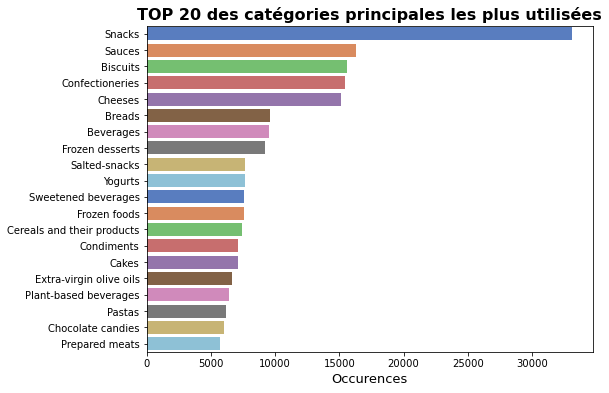

In [185]:
main_category_en_count = openfoodfacts_en['main_category_en'].value_counts()[0:20]

plt.figure(figsize=(8, 6))
sns.barplot(y = main_category_en_count.index, x = main_category_en_count.values, palette = 'muted')
plt.title("TOP 20 des catégories principales les plus utilisées")
plt.ylabel("")
plt.xlabel("Occurences");

Cette variable pourrait être utilisée pour permettre de proposer un produit équivalent, mieux noté.

#### Groupes pnns

Le Programme national nutrition santé a été créé en 2001, et son site grand public a été lancé à la rentrée 2004, par l'Agence française de sécurité sanitaire des aliments et poursuivi par l'Agence nationale de santé publique. 

Ce programme a pour objectif général l’amélioration de l’état de santé de l’ensemble de la population en agissant sur l’un de ses déterminants majeurs : la nutrition. Ce programme agit à plusieurs niveaux: industrie, consommateurs, recherche afin d'atteindre ses objectifs (par exemple : diminution de la consommation de sel).

In [186]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'pnns')

In [187]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,pnns_groups_1,object,unknown,2053679,12,0.0,2053552,99.99,127,0.01
1,pnns_groups_2,object,unknown,2053679,42,0.0,2053554,99.99,125,0.01


In [188]:
tab_modalities

,pnns_groups_1,pnns_groups_2
735693,Fish Meat Eggs,Fish and seafood
567192,unknown,unknown
374344,unknown,unknown
1470657,unknown,unknown
1397921,unknown,unknown


Les variables pnns_groups n'ont que 0.01 % de NaN, mais il semble y avoir la mention "unknown" qui correspond en réalité à une valeur non renseignée. Regardons les différentes modalités de ces variables.

In [189]:
# Vérification des mentions unknown
openfoodfacts_en[openfoodfacts_en[['pnns_groups_1', 'pnns_groups_2']]== "unknown"][
    ['pnns_groups_1', 'pnns_groups_2']]

,pnns_groups_1,pnns_groups_2
0,unknown,unknown
1,unknown,unknown
2,unknown,unknown
3,unknown,unknown
4,unknown,unknown
...,...,...
2053674,unknown,unknown
2053675,unknown,unknown
2053676,unknown,unknown
2053677,unknown,unknown


Il semblerait que quand l'un des groupes pnns soit unknown, l'autre le soit aussi. Regardons si l'on peut obtenir plus d'information en rajoutant la colonne main_category_en.

In [191]:
openfoodfacts_en[openfoodfacts_en[['pnns_groups_1', 'pnns_groups_2', 'main_category_en']].notnull().all(1)][
    ['pnns_groups_1', 'pnns_groups_2', 'main_category_en']]

,pnns_groups_1,pnns_groups_2,main_category_en
7,Fat and sauces,Dressings and sauces,Mustards
16,unknown,unknown,Almond paste
17,Composite foods,One-dish meals,Seasoned shredded carrots
26,Sugary snacks,Biscuits and cakes,Coconut pies
36,Fruits and vegetables,Fruits,Pear compotes
...,...,...,...
2053667,unknown,unknown,Sweet Fritters
2053670,Sugary snacks,Biscuits and cakes,de:tiefkühl-kuchen
2053671,Fish Meat Eggs,Meat,Ground beef steaks
2053672,Sugary snacks,Sweets,Marrons glacés


Nous allons remplacer la mention unknown des pnns_groups_1 et pnns_groups_2 par np.nan afin de connaitre le nombre réel de valeurs manquantes.

In [ ]:
openfoodfacts_en['pnns_groups_1'].value_counts()

In [ ]:
openfoodfacts_en['pnns_groups_2'].value_counts()

In [ ]:
openfoodfacts_en['pnns_groups_1'].unique().tolist()

## Sélection de variables pertinentes en lien avec le choix d'application <a class="anchor" id="selec_var"></a>

<div class="alert alert-block alert-warning">
    <p> Suppression de variables pour libérer de la RAM </p>
</div>

L'agence "Santé publique France" a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. Je souhaite y contribuer en proposant **une nouvelle signalétique permettant aux femmes enceintes de s'assurer que le produit ne contient pas d'aliment proscrit pendant la grossesse et de proposer une alternative avec le meilleur nutriscore si le produit sélectionné ne convient pas**.

Je me suis basée sur le guide nutrition de la grossesse dont les données proviennent de l'Agence française de sécurité sanitaire des aliments (AFSSA) disponibles en téléchargement sur le site de Santé Publique France à cette adresse: https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/documents/brochure/le-guide-nutrition-de-la-grossesse

On y retrouve les vitamines et oligoéléments essentiels pendant la grossesse tels que: 
- les **folates** (vitamine B9) pour le développement du système nerveux de l'embryon 
- le **calcium** (construction du squelette de l'enfant)
- la **viatmine D** qui permet à l'organisme à mieux absorber le calcium des aliments
- le **fer**
- l'**iode** (fonctionnement de la glande thyroïde + développement cerveau de l'enfant)


Certains aliments sont à proscrire pendant la grossesse ou à manger en petite quantité. Parmis eux: 
- le **soja**
- **certains poissons**: anguille, barbeau, brème, carpe, silure, lotte, bar, bonite, empereur, grenadier, flétan, brochet, dorade, raie, sabre, thon, espadon, marlin, siki, requin, lamproie
- les boissons contenant de la **caféine**
- le foie et les **produits à base de foie**
- les **fromages à pâte molle à croûte fleurie** (type camembert, brie) et à **croûte lavée** (type munster, pont- l’évêque), surtout s’ils sont au lait cru ; les **fromages râpés industriels**
- certains produits de charcuterie, notamment **rillettes, pâtés, foie gras, produits en gelée**
- la **viande crue** ou peu cuite, le **poisson cru** (sushi, sashimi, tarama), les **poissons fumés** (saumon, truite),et les **crustacés décortiqués vendus cuits**
- les produits enrichis en **phytostérols**
- l'**alcool**

Nous allons donc filtrer le dataset sur les variables qui nous apportent de l'information sur les éléments ci-dessus. Notre application aura pour cible les femmes enceintes qui achètent en France. Il est en effet obligatoire de traduire les étiquettes dans la langue où le produit est vendu ce qui facilitera l'analyse. Cette application pourrait être adaptée à différents pays ultérieurement.

In [ ]:
# Copie du dataset
openfoodfacts_light = openfoodfacts_en.copy()

### Informations sur les produits  <a class="anchor" id="vitamines"></a>

In [ ]:
liste_var_categ = ['code', 'last_modified_date', 'product_name', 'categories_en', 'labels_en', 
                   'countries_en', 'ingredients_text', 'allergens', 'nutriscore_grade', 
                  'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'main_category_en']

In [ ]:
openfoodfacts_light.iloc[:, openfoodfacts_light.columns.isin(liste_var_categ)]

In [ ]:
openfoodfacts_light.iloc[:, ~openfoodfacts_light.columns.str.endswith('_100g')]

### Vitamines et oligoéléments essentiels  <a class="anchor" id="vitamines"></a>

Les nutriments sont des variables distinctes dans le dataset. Nous allons filtrer ce dernier sur les nutriments essentiels traduits en anglais.

In [ ]:
# Liste des nutriments essentiels
liste_nutriments_essentiels = openfoodfacts_en.iloc[:,openfoodfacts_en.columns.str.contains(
    'folates|vitamin-b9|calcium|vitamin-d|iron|iodine|alcohol')].columns.tolist()

### Aliments à proscrire  <a class="anchor" id="proscrire"></a>

In [ ]:
openfoodfacts_en.columns.tolist()

Les aliments à proscrire sont des modalités de la variable

In [ ]:
# Liste des aliments à proscrire

In [ ]:
openfoodfacts_en[openfoodfacts_en['ingredients_text'].str.contains(
    'soja|caféine|foie|phytostérols', na = False)][['product_name', 'ingredients_text', 'countries_en']]

In [ ]:
liste_var_categ = ['code','last_modified_date','last_modified_year','product_name', 
                   'brands_tags','categories_en','labels_en','countries_en','ingredients_text','allergens',
                   'traces_en','serving_quantity','additives_n','additives_en','nova_group','pnns_groups_1',
                   'pnns_groups_2','brand_owner','ecoscore_score_fr','ecoscore_grade_fr','main_category',
                   'main_category_en','energy-kcal_100g','energy_100g','energy-from-fat_100g','fat_100g']

liste_a_eviter =  ['caffeine_100g', 'taurine_100g', 'salt_100g', 'sodium_100g', 'alcohol_100g', 'sugars_100g']

, 
        

liste_nutriscore = ['nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'nutriscore_score', 
                    'nutriscore_grade']

In [ ]:
describe_variables_light(openfoodfacts_en)

[Retour à la table des matières](#0)

<div class="alert alert-block alert-info">
    <p> Si on filtre sur le nom des ingrédients en français, peut être qu'il n'y a pas besoin de filtrer sur le pays </p>
</div>